# Recomendation System

**Author:** Bridget Coleman
***

# Overview

I am looking at movie recommendations for users based on movies that they have currently rated.  


# Data Understanding

The data is from the MovieLens dataset from the GroupLens research lab at the University of Minnesota.

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from surprise import Dataset, Reader
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, SVDpp, KNNBaseline
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV


links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')


In [2]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
movies['genres'].value_counts()

Drama                                              1053
Comedy                                              946
Comedy|Drama                                        435
Comedy|Romance                                      363
Drama|Romance                                       349
                                                   ... 
Action|Adventure|Drama|Romance|Thriller|Western       1
Adventure|Animation|Children|Musical|Western          1
Action|Fantasy|Mystery                                1
Adventure|Documentary|Western                         1
Adventure|Mystery|Thriller                            1
Name: genres, Length: 951, dtype: int64

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
tags['tag'].value_counts()

In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
surreal               23
                    ... 
con artists            1
gintama                1
space station          1
Michigan               1
Animation              1
Name: tag, Length: 1589, dtype: int64

In [10]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [11]:
ratings = ratings.drop(columns='timestamp')
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [12]:
print('Number of Users: ', len(ratings['userId'].unique()))
print('Number of Movies: ', len(ratings['movieId'].unique()))


Number of Users:  610
Number of Movies:  9724


In [13]:
ratings['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

In [14]:
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [15]:
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


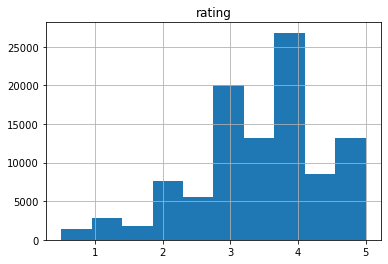

In [16]:
ratings.hist(column='rating');

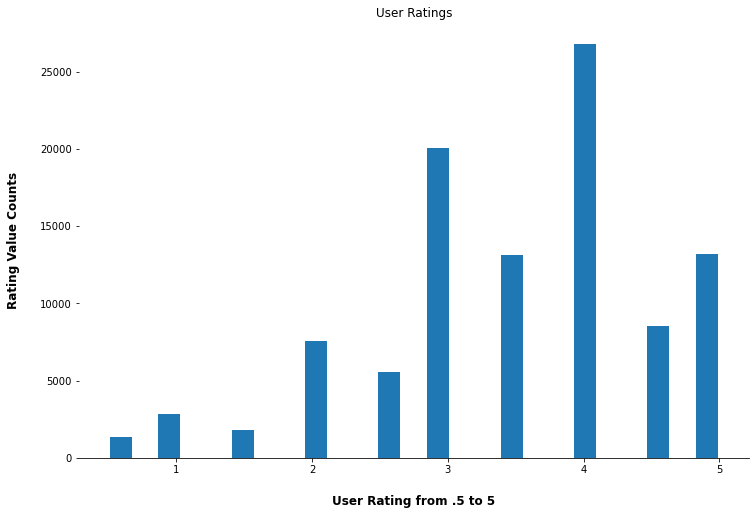

In [17]:
ax = ratings.hist(column='rating', bins=25, grid=False, figsize=(12,8), zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

       
    # Set title
    x.set_title("User Ratings")

    # Set x-axis label
    x.set_xlabel("User Rating from .5 to 5", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Rating Value Counts", labelpad=20, weight='bold', size=12)

    


In [18]:
tags = tags.drop(columns='timestamp')
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [19]:
print('Number of Users: ', len(tags['userId'].unique()))

Number of Users:  58


In [20]:
movie_rate = pd.merge(ratings, movies, on="movieId")
movie_rate.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


# Fitting and evalutating models

In [21]:
data = Dataset.load_builtin('ml-100k')

data

In [22]:
reader = Reader()
data = Dataset.load_from_df(ratings,reader)

In [23]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [24]:
svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8735  0.8705  0.8695  0.8707  0.8807  0.8730  0.0041  
MAE (testset)     0.6675  0.6697  0.6697  0.6686  0.6769  0.6705  0.0033  
Fit time          3.67    3.78    3.75    3.59    3.63    3.68    0.07    
Test time         0.17    0.13    0.12    0.17    0.17    0.15    0.02    


{'test_rmse': array([0.87347809, 0.87048712, 0.86954418, 0.87073821, 0.88072004]),
 'test_mae': array([0.6675004 , 0.66968616, 0.66969037, 0.66860142, 0.67694177]),
 'fit_time': (3.6692898273468018,
  3.777430295944214,
  3.752838611602783,
  3.5866305828094482,
  3.6307055950164795),
 'test_time': (0.17322015762329102,
  0.12828469276428223,
  0.12024235725402832,
  0.17186403274536133,
  0.1718614101409912)}

In [25]:
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [26]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.96556751, 0.97925263, 0.96494013, 0.97764695, 0.97028002]))
('test_mae', array([0.74597448, 0.75468261, 0.74364708, 0.75579282, 0.75095548]))
('fit_time', (0.8944814205169678, 1.0350899696350098, 1.143585443496704, 0.9960765838623047, 0.9640946388244629))
('test_time', (1.8693113327026367, 2.0274808406829834, 1.50346040725708, 1.5503294467926025, 1.683650255203247))
-----------------------
0.971537448339444


In [27]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [28]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.86492046, 0.88268782, 0.87804768, 0.87600864, 0.87893254]))
('test_mae', array([0.66166239, 0.67564623, 0.67143513, 0.67168009, 0.66493951]))
('fit_time', (0.7305805683135986, 0.7280683517456055, 0.7347829341888428, 0.7352149486541748, 0.8651642799377441))
('test_time', (1.6508536338806152, 1.6394004821777344, 1.6811461448669434, 1.8070271015167236, 1.9446942806243896))


0.8761194301708752

In [29]:
train, test = train_test_split(data, test_size=.2)

Based on the results, the best model is SVD.

In [32]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(dataset)

In [41]:
svd.predict(2,500)

Prediction(uid=2, iid=500, r_ui=None, est=3.599943785478982, details={'was_impossible': False})

In [36]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movies['genres'].str.contains(genre)].sample(1)
        else:
            movie = movies.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list 

In [37]:
user_rating = movie_rater(movies, 4, 'Comedy')

      movieId                  title  genres
2338     3096  My Man Godfrey (1957)  Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


     movieId                                            title  \
924     1223  Grand Day Out with Wallace and Gromit, A (1989)   

                                         genres  
924  Adventure|Animation|Children|Comedy|Sci-Fi  


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


     movieId             title                                    genres
337      380  True Lies (1994)  Action|Adventure|Comedy|Romance|Thriller


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 3


      movieId                         title        genres
4120     5912  Hit the Bank (Vabank) (1981)  Comedy|Crime


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                 title          genres
7758    91337  Play the Game (2009)  Comedy|Romance


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                      title  genres
6222    45726  You, Me and Dupree (2006)  Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 1


      movieId                 title               genres
7981    96655  Robot & Frank (2012)  Comedy|Drama|Sci-Fi


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                       title          genres
2132     2837  Bedrooms & Hallways (1998)  Comedy|Romance


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                          title        genres
2926     3925  Stranger Than Paradise (1984)  Comedy|Drama


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                         title                      genres
8462   112460  Planes: Fire & Rescue (2014)  Adventure|Animation|Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId        title                genres
5506    26422  Hair (1979)  Comedy|Drama|Musical


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


     movieId         title        genres
164      194  Smoke (1995)  Comedy|Drama


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId           title          genres
3687     5077  Cousins (1989)  Comedy|Romance


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                                              title  genres
2094     2788  Monty Python's And Now for Something Completel...  Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 5


      movieId                                  title           genres
7962    96283  Diary of a Wimpy Kid: Dog Days (2012)  Children|Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                          title  genres
7019    68444  Great Buck Howard, The (2008)  Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                         title        genres
3628     4979  Royal Tenenbaums, The (2001)  Comedy|Drama


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                           title        genres
6206    45440  Art School Confidential (2006)  Comedy|Drama


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


     movieId                title                          genres
870     1151  Lesson Faust (1994)  Animation|Comedy|Drama|Fantasy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                 title              genres
6738    59143  Super High Me (2007)  Comedy|Documentary


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 n


      movieId                   title  genres
2441     3254  Wayne's World 2 (1993)  Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 2


In [38]:
user_rating

[{'userId': 1000, 'movieId': 380, 'rating': '3'},
 {'userId': 1000, 'movieId': 45726, 'rating': '1'},
 {'userId': 1000, 'movieId': 2788, 'rating': '5'},
 {'userId': 1000, 'movieId': 3254, 'rating': '2'}]

In [39]:
new_ratings_df = ratings.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [40]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


# Recommendations for the new user

In [44]:
svd_ = SVD(n_factors= 50, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

In [46]:
list_of_movies = []
for m_id in ratings['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [47]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [53]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,10)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  3 :  966    Manchurian Candidate, The (1962)
Name: title, dtype: object 

Recommendation #  4 :  922    Godfather: Part II, The (1974)
Name: title, dtype: object 

Recommendation #  5 :  659    Godfather, The (1972)
Name: title, dtype: object 

Recommendation #  6 :  9618    Three Billboards Outside Ebbing, Missouri (2017)
Name: title, dtype: object 

Recommendation #  7 :  6016    Kiss Kiss Bang Bang (2005)
Name: title, dtype: object 

Recommendation #  8 :  2094    Monty Python's And Now for Something Completel...
Name: title, dtype: object 

Recommendation #  9 :  6153    Thank You for Smoking (2006)
Name: title, dtype: object 

Recommendation #  10 :  2226    Fight Club (1999)
Name: title, dtype: object 

